## Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural similar a do Bengio 2003 para prever a próxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Linguagem".

Portanto, você deve implementar o modelo de linguagem inspirado no artigo do Bengio, para prever a próxima palavra usando rede com embeddings e duas camadas.
Sugestão de alguns parâmetros:
* context_size = 9
* max_vocab_size = 3000
* embedding_dim = 64
* usar pontuação no vocabulário
* descartar qualquer contexto ou target que não esteja no vocabulário
* É esperado conseguir uma perplexidade da ordem de 50.
* Procurem fazer asserts para garantir que partes do seu programa estão testadas

Este enunciado não é fixo, podem mudar qualquer um dos parâmetros acima, mas procurem conseguir a perplexidade esperada ou menor.

Gerem alguns frases usando um contexto inicial e depois deslocando o contexto e prevendo a próxima palavra gerando frases compridas para ver se está gerando texto plausível.

Algumas dicas:
- Inclua caracteres de pontuação (ex: `.` e `,`) no vocabulário.
- Deixe tudo como caixa baixa (lower-case).
- A escolha do tamanho do vocabulario é importante: ser for muito grande, fica difícil para o modelo aprender boas representações. Se for muito pequeno, o modelo apenas conseguirá gerar textos simples.
- Remova qualquer exemplo de treino/validação/teste que tenha pelo menos um token desconhecido (ou na entrada ou na saída).
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

Procure por `TODO` para entender onde você precisa inserir o seu código.

In [899]:
import string
from collections import Counter
from typing import List, Dict, Union, Tuple
import random
import os
import time

import numpy as np
from numpy.testing import assert_raises, assert_array_equal
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tqdm
import matplotlib.pyplot as plt


Inicializa os geradores randômicos

In [721]:
random.seed(18)
torch.manual_seed(18)

Parâmetros do modelo

In [722]:
vocab_size = 3000 # Quantidade de palavras no vocabulário
context_size = 4 # n palavras de entrada. O target é a próxima palavra
embed_dim = 64 # Tamanho do feature vector de cada palavra
hidden_units = 300 # Quantidade de unidades na camada escondida
epochs = 10 # Quantidade de epochs que serão treinadas
lr = 5e-1 # Taxa de treinamento
weight_decay = 1e-3 # Regularização

## Faz download e carrega o dataset

In [723]:
#!wget https://www.gutenberg.org/ebooks/67724.txt.utf-8
#!wget https://www.gutenberg.org/ebooks/67725.txt.utf-8

In [724]:
if not os.path.isfile("67724.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67724.txt.utf-8

if not os.path.isfile("67725.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67725.txt.utf-8

In [792]:
text = open("67724.txt.utf-8","r", encoding="utf8").read()
text += open("67725.txt.utf-8","r", encoding="utf8").read()

paragraphs = text.split("\n\n")
len(paragraphs)

4969

In [799]:
def clean_text(text:str) -> str:
    '''
    Clean the text, changing upper case and setting numbers to 999
    '''
    
    text = text.lower()
    old_text = text.split()
    new_text = []

    for j in range(len(old_text)):
        word = old_text[j] 
        if word.isdigit():
            word = "999"
        elif len(word) > 1 and word[0] in string.punctuation:
            old_text.insert(j+1, word[1:])
            word = word[0]
        elif word[-1] in string.punctuation and len(word) > 1:
            old_text.insert(j+1, word[:-1])
            old_text.insert(j+2, word[-1])
            
            word = ""
        
        if len(word) > 0:
            new_text.append(word)
    
    return " ".join(new_text)

In [800]:
cleaned_paragraphs = [paragraph.replace("\n", " ") for paragraph in paragraphs if paragraph.strip()]

#Paper:
#ponctuation -> keep (separado das outras palavras, "pontuação," -> "pontuação"+",")
#numeric -> special symbol (colocando todos como 999 para convergir para o mesmo símbolo)
#upper -> lower
#proper nouns -> special symbol (difícil identificar, ignorado)
#rare words -> special symbol (feito na parte de encoding)

for i in range(len(cleaned_paragraphs)):
    cleaned_paragraphs[i] = clean_text(cleaned_paragraphs[i])

print("SAMPLE ----------------")
print(cleaned_paragraphs[0])
print("---------------------")

print(len(cleaned_paragraphs))



SAMPLE ----------------
﻿the project gutenberg ebook of o guarany : romance brazileiro , vol . 999 ( of 999 ) this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever . you may copy it , give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org . if you are not located in the united states , you
---------------------
4892


In [728]:
del paragraphs, text

## Análise do dataset

In [729]:

def count_words(texts:List[str]) -> Counter:
    word_counts = Counter()
    for text in texts:
        #Regular expression removes ponctuation
        #word_counts.update(re.findall(r'\w+', text.lower())) 
        word_counts.update(text.split(" "))
    return word_counts

word_counts = count_words(cleaned_paragraphs)

len(word_counts)

11470

## Criando um vocabulário

In [730]:
most_frequent_words = [word for word, count in word_counts.most_common(vocab_size)]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}

In [731]:
def encode_sentence(sentence:Union[str,List[str]], vocab:Dict) -> List[int]:
    if isinstance(sentence, list):
        words = sentence
    else:
        words = sentence.split(" ") #Removido o regex por não pegar pontuação e ser ~3x mais lento
    
    return [vocab.get(word, 0) for word in words]

Checando se o encoding faz sentido:

In [732]:
print("20 palavras mais frequentes:", most_frequent_words[:20])

20 palavras mais frequentes: [',', 'a', 'que', '-', 'o', 'de', 'e', ';', '.', 'um', 'do', 'não', 'uma', 'os', 'se', 'da', 'com', 'sua', 'para', 'seu']


As palavras mais frequentes são pontuações, potencialmente problemático.

In [733]:
encoded20 = encode_sentence(cleaned_paragraphs[20], vocab)
words = cleaned_paragraphs[20].split(" ")

for i in range(len(words)):
    print(words[i], encoded20[i])

publicando 0
este 126
livro 0
em 21
999 153
, 1
se 15
disse 57
ser 122
aquella 221
primeira 197
edição 2103
uma 13
prova 960
typographica 0
, 1
que 3
algum 192
dia 134
talvez 281
o 5
autor 2105


O encoding funciona, gerando também símbolos desconhecidos

Decoding

In [734]:
inverse_vocab = list(vocab.keys())

In [735]:
def decode_sentence(encoding, inverse_vocab):
    result = []

    for encoding_i in encoding:
        if encoding_i == 0:
            result.append("???")
        else:
            result.append(inverse_vocab[encoding_i-1])

    return result

In [736]:
decoded20 = decode_sentence(encoded20, inverse_vocab)

for i in range(len(words)):
    print(words[i], "|", decoded20[i])

    if decoded20[i] != "???":
        assert words[i] == decoded20[i]

publicando | ???
este | este
livro | ???
em | em
999 | 999
, | ,
se | se
disse | disse
ser | ser
aquella | aquella
primeira | primeira
edição | edição
uma | uma
prova | prova
typographica | ???
, | ,
que | que
algum | algum
dia | dia
talvez | talvez
o | o
autor | autor


E o decoding também consegue retornar a sequência original (exceto pelos símbolos desconhecidos)

In [737]:
del word_counts, most_frequent_words, encoded20, words, decoded20

## Classe do dataset

In [900]:
def create_sequences(texts:List[str], context_size:int, 
                     vocab:Dict) -> Tuple[List[List[int]], List[int]]:
    '''
    Generates
    '''
    x_all = []
    y_all = []

    for paragraph in texts:
        start = 0
        end = context_size

        paragraph = encode_sentence(paragraph, vocab)

        while end < len(paragraph):
            x = paragraph[start:end]
            y = paragraph[end]

            if not ( 0 in x or 0 == y):
                x_all.append(x)
                y_all.append(y)

            start += 1
            end += 1
    return x_all, y_all

In [901]:
x_all, y_all = create_sequences(cleaned_paragraphs, context_size, vocab)

Checando se o dataset está correto

In [902]:
print(encode_sentence(cleaned_paragraphs[0], vocab))

for i in range(3):
    print(x_all[i], "|", y_all[i])

[0, 68, 214, 493, 48, 5, 684, 44, 866, 867, 1, 0, 9, 153, 348, 48, 153, 383, 145, 493, 309, 262, 37, 494, 48, 957, 2095, 106, 37, 411, 329, 92, 958, 412, 2096, 48, 37, 2097, 645, 24, 1492, 92, 136, 2098, 24, 2099, 2100, 9, 82, 446, 495, 384, 1, 1493, 384, 2101, 93, 2102, 384, 802, 37, 276, 48, 37, 68, 214, 447, 1494, 136, 145, 493, 93, 1495, 645, 1496, 9, 263, 82, 252, 215, 803, 106, 37, 411, 329, 1, 82]
[68, 214, 493, 48] | 5
[214, 493, 48, 5] | 684
[493, 48, 5, 684] | 44


In [741]:
len(x_all)

45366

In [742]:
assert len(x_all) == len(y_all)

Divisão treino|validação|teste

60%|20%|20%

OBS: seed determinada no início do notebook

In [743]:
#Embaralhando para evitar viés
indexes = list(range(len(x_all)))
random.shuffle(indexes)

x_all = np.array(x_all)
y_all = np.array(y_all)

x_all = x_all[indexes]
y_all = y_all[indexes]

In [744]:
size_all = len(x_all)

cut1 = int(0.6*size_all)
cut2 = int(0.8*size_all)

x_train = x_all[0:cut1]
y_train = y_all[0:cut1]

x_val = x_all[cut1:cut2]
y_val = y_all[cut1:cut2]

x_test = x_all[cut2:]
y_test = y_all[cut2:]

In [745]:
n_train = len(x_train)
n_val = len(x_val)
n_test = len(x_test)

In [746]:
print("Treino:", n_train)
print("Validação:", n_val)
print("Teste:", n_test)

Treino: 27219
Validação: 9073
Teste: 9074


In [747]:
assert n_train+n_val+n_test == size_all

Classe para o dataset

OBS: utilizar tensores q [context_size x vocab_size] esparsos utiliza muita memória, preferi alterar a primeira camada para evitar precisar gerar estes tensores

In [748]:
class TextPredictDataset(Dataset):
    def __init__(self, x_data:List[int], y_data:List[int]):
        self._x_data = torch.tensor(x_data)-1
        self._y_data = torch.tensor(y_data, dtype=torch.int64)-1
        
        if len(x_data) != len(y_data):
            raise ValueError(f"x_data and y_data must have same size. ({len(x_data)} ≠ {len(y_data)})")
        
        self._size = len(x_data)

    def __len__(self):
        return self._size

    def __getitem__(self, idx):
        return self._x_data[idx], self._y_data[idx]


In [749]:
train_data = TextPredictDataset(x_train, y_train)
val_data = TextPredictDataset(x_val, y_val)
test_data = TextPredictDataset(x_test, y_test)

In [750]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [751]:
sample_batch = next(iter(train_loader))

## Model

In [752]:

class LanguageModel(nn.Module):

    def __init__(self, context_size:int, vocab_size:int, embed_dim:int, hidden_units:int):
        super().__init__()

        self.C = torch.Tensor(vocab_size, embed_dim)
        nn.init.xavier_uniform_(self.C)
        self.C = torch.nn.Parameter(self.C)
        
        
        #V = |Vocab|, m = |Embed|
        #n-1 = c = |Context|
        #h = |Hidden|
        
        #C[V, m](input) -> x[c*m]
        #Linear1(x) -> x2[h]
        #ReLU(x2) -> x3[h]  | alterado do paper (tanh)
        #Linear2(x) -> x4[V]
        #Linear3(x3) -> x5[V] | sem bias (Linear2 já tem bias)
        #Add(x4, x5) -> output
        #Sem softmax -> melhor estabilidade

        m = int(context_size*embed_dim)

        self.linear1 = nn.Linear(m, hidden_units)
        self.relu = nn.ReLU() 
        self.linear2 = nn.Linear(m, vocab_size)
        self.linear3 = nn.Linear(hidden_units, vocab_size, bias=False)

    def forward(self, input_x:torch.Tensor) -> torch.Tensor:
        #No batch: x = torch.index_select(self.C, 0, input_x).flatten()
        x = torch.stack([torch.index_select(self.C, 0, input_i).flatten() for input_i in input_x])
        
        x2 = self.linear1(x)
        x3 = self.relu(x2)
        x4 = self.linear2(x)
        x5 = self.linear3(x3)

        output = x4+x5

        return output

In [753]:
model = LanguageModel(context_size, vocab_size, embed_dim, hidden_units)

Checando se o modelo funciona corretamente

In [754]:
# sample = next(iter(train_loader))
inputs = sample_batch[0]
targets = sample_batch[1]

In [755]:
outputs = model(inputs)

In [756]:
outputs.argmax(dim=1)

tensor([1431,  531, 1431, 2044, 1493, 2365, 2007,  182, 2396, 1181,  928, 1431,
        1431, 1431, 1309,   36, 1431,   36,  838, 2265, 1204, 1772, 1431, 1866,
        1431, 1431, 1431, 1431,  928,  838, 2243,  179])

In [757]:
targets

tensor([ 891, 1064,  265, 1080,   68,    4,   72, 2778,    0, 1857,    9,   15,
         592,   24,   12,  112,   16, 1486,    1,   10,    2, 1996,    0,    0,
           6,  742,    5,  549,   25, 2170,  482,  732])

In [758]:
assert outputs.argmax(dim=1).shape == targets.shape

Checando se a quantidade de parâmetros está igual ao artigo

In [759]:
#V = |Vocab|, m = |Embed|
#n-1 = c = |Context|
#h = |Hidden|

n_param_real = sum([p.numel() for p in model.parameters()])

m = embed_dim
n = context_size+1
V = vocab_size
h = hidden_units

n_param_theoretical = V*(1+(n*m)+h)
n_param_theoretical += h*(1+((n-1)*m))

assert n_param_real == n_param_theoretical

In [760]:
print(n_param_real, "parâmetros")

1940100 parâmetros


Sanity check: C está sendo treinado

In [761]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [762]:
old_C = model.C.detach().numpy()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=10)

model = model.to(device)
model.train()

inputs = inputs.to(device)
targets = targets.to(device)

logits = model(inputs)
loss = criterion(logits.squeeze(), targets)
optimizer.zero_grad()
loss.backward()
optimizer.step()

new_C = model.C.cpu().detach().numpy()

In [763]:
assert_raises(AssertionError, assert_array_equal, old_C, new_C)
np.max(np.abs(old_C-new_C))

10.0043955

## Training

In [776]:
model = LanguageModel(context_size, vocab_size, embed_dim, hidden_units)
model.to(device);

In [777]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

#Adam e AdamW -> Overfit
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1) 

In [778]:
def ppl(loss):
    return torch.exp(loss)

In [779]:
def compute_loss(model, loader, criterion):
    model.eval()

    with torch.no_grad():
        total_loss = 0
        n = 0
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)
            loss = criterion(logits.squeeze(), targets)
            total_loss += loss*targets.size(0)

            n += targets.size(0)

        total_loss /= n 
    
    return total_loss.detach()

In [780]:
def print_info(loss_value, epoch, total_epochs, time=0.0):
    ppl_value = ppl(loss_value)

    
    print(f'Epoch [{epoch+1}/{total_epochs}], \
            Loss: {loss_value.item():.4f}, \
            Perplexity: {ppl_value.item():.4f}', end="")
    
    if time != 0:
        print(f", Elapsed Time: {time:.2f} sec")    
    else:
        print("")
            

In [781]:
hist = {}
hist["loss_train"] = []
hist["loss_val"] = []
hist["ppl_train"] = []
hist["ppl_val"] = []

prev_loss = compute_loss(model, train_loader, criterion)
print_info(prev_loss, -1, epochs, 0)

for epoch in range(epochs):
    start_time = time.time() 

    model.train()

    loss_train = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        logits = model(inputs)
        loss = criterion(logits.squeeze(), targets)
        loss_train += loss*targets.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time() 
    epoch_duration = end_time - start_time 

    loss_train /= n_train
    ppl_train = ppl(loss_train)

    print_info(loss_train, epoch, 0, epoch_duration)
    
    print("VAL ", end="")
    loss_val = compute_loss(model, val_loader, criterion)
    ppl_val = ppl(loss_val)
    print_info(loss_val, epoch, epochs)

    hist["loss_train"].append(loss_train.item())
    hist["loss_val"].append(loss_val.item())
    hist["ppl_train"].append(ppl_train.item())
    hist["ppl_val"].append(ppl_val.item())

Epoch [0/10],             Loss: 8.0134,             Perplexity: 3021.0713
Epoch [1/0],             Loss: 6.1146,             Perplexity: 452.4352, Elapsed Time: 3.60 sec
VAL Epoch [1/10],             Loss: 5.7786,             Perplexity: 323.3106
Epoch [2/0],             Loss: 5.5459,             Perplexity: 256.1867, Elapsed Time: 3.56 sec
VAL Epoch [2/10],             Loss: 5.4864,             Perplexity: 241.3810
Epoch [3/0],             Loss: 5.2686,             Perplexity: 194.1376, Elapsed Time: 3.39 sec
VAL Epoch [3/10],             Loss: 5.3496,             Perplexity: 210.5273
Epoch [4/0],             Loss: 5.0797,             Perplexity: 160.7330, Elapsed Time: 3.40 sec
VAL Epoch [4/10],             Loss: 5.2498,             Perplexity: 190.5263
Epoch [5/0],             Loss: 4.9542,             Perplexity: 141.7622, Elapsed Time: 3.42 sec
VAL Epoch [5/10],             Loss: 5.1880,             Perplexity: 179.1080
Epoch [6/0],             Loss: 4.8713,             Perplexity

In [782]:
for key in hist:
    hist[key] = np.array(hist[key])

Pelos gráficos podemos observar que o modelo treina, com um pouco de overfitting, porém sem divergir completamente a perda de validação:

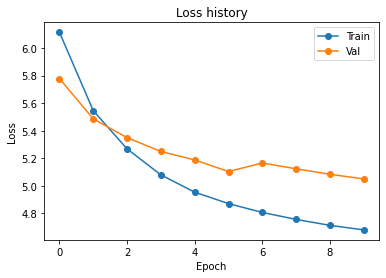

In [783]:
plt.plot(hist["loss_train"], "o-")
plt.plot(hist["loss_val"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")

plt.show()

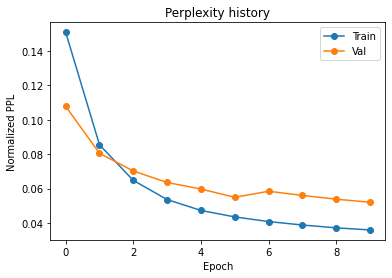

In [784]:
plt.plot(hist["ppl_train"]/vocab_size, "o-")
plt.plot(hist["ppl_val"]/vocab_size, "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Normalized PPL")
plt.title("Perplexity history")

plt.show()

In [785]:
#For manual logging 
#print(context_size, embed_dim, hidden_units, lr, weight_decay, epochs, hist["ppl_train"][-1], hist["ppl_val"][-1])

4 64 300 0.5 0.001 10 107.80912017822266 156.05552673339844


In [894]:
torch.save(model, "model")

## Avaliação

In [789]:
test_loss = compute_loss(model, test_loader, criterion)
test_ppl = ppl(test_loss)

test_ppl.item()

146.00650024414062

## Exemplo de uso

In [895]:
model = torch.load("model")

In [896]:
def generate_text(model, vocab, inverse_vocab, text, max_length):
    text = clean_text(text)

    total_length = len(text.split(" "))

    last_sequence = create_sequences([text], context_size, vocab)[0][-1]
    last_sequence = torch.tensor(last_sequence)-1
    last_sequence = last_sequence.to(device)

    new_characters = []

    while total_length < max_length:
        
        output = model(torch.unsqueeze(last_sequence, 0))
        
        next_encoded = output.argmax(dim=1).item()

        last_sequence = torch.cat((last_sequence[1:], torch.tensor([next_encoded]).to(device)))
        
        new_characters.append(next_encoded)

        total_length += 1

    new_characters = np.array(new_characters)+1

    new_text = " ".join(decode_sentence(new_characters, inverse_vocab))

    return new_text

In [897]:
text = cleaned_paragraphs[300]
max_length = 40

new_text = generate_text(model, vocab, inverse_vocab, text, max_length)

print("OLD")
print(text)
print("")
print("GENERATED CONTINUATION")
print(new_text)

OLD
- - tu não abandonarás tua senhora , não é ? disse ella passando a

GENERATED CONTINUATION
a sua alma e a sua alma de sua senhora , e a moça , e a moça , e a moça , e a


Podemos observar que o modelo colapsa rapidamente para uma sequência, neste caso ", e a moça".